# PM2.5 time-series prediction model with SARIMAX + additional scraped hotspot and traffic data

Prerequisite : statsmodels latest version (may require restarting)

In [ ]:
!pip install -U statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import os
import statsmodels.api as sm

# Data Preparation

In [4]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  # Download resources from Github
  !apt install subversion
  !svn checkout https://github.com/Gyoowai/PM25_Kaggle_2022/trunk/scraped_dataset https://github.com/Gyoowai/PM25_Kaggle_2022/trunk/datasci_dataset_2022

In [5]:
# Declare Variables
province = [("BKK","bkk"), 
            ("Chiangmai","chiangmai"),  
            ("Rayong","rayong"), 
            ("Saraburi","saraburi"), 
            ("Khonkaen","khonkaen"), 
            ("Surat","surat")
            ] # submission order
wind_name = "_weather_wind.csv"
temp_name = "_temp_surface.csv"
train_name = "_train.csv"

## Get Scraped Hotspot Data

In [6]:
def pullHotspot():
    path = 'scraped_dataset/hotspot.csv'
    df = pd.read_csv(os.path.abspath(path))

    # Setting DatetimeIndex and resample into 6-hour steps
    df = df.rename(columns={'Unnamed: 0':'DateTime'})
    df['DateTime'] = pd.to_datetime(df['DateTime'],dayfirst=True)
    df = df.set_index('DateTime')
    df = df.resample('6h').ffill()
    
    return df

In [7]:
hotspot = pullHotspot()
# Trimming excess rows
hotspot= hotspot.iloc[2:-1,:]
hotspot

,Cambodia,Lao_PDR,Thailand,Myanmar
DateTime,,,,
2017-07-01 12:00:00,3,0,0,0
2017-07-01 18:00:00,3,0,0,0
2017-07-02 00:00:00,0,0,0,0
2017-07-02 06:00:00,0,0,0,0
2017-07-02 12:00:00,0,0,0,0
...,...,...,...,...
2021-06-30 18:00:00,5,0,0,0
2021-07-01 00:00:00,6,0,2,0
2021-07-01 06:00:00,6,0,2,0


## Get Scraped Traffic Data

In [8]:
def pullTraffic():
    path = 'scraped_dataset/traffic.csv'
    df = pd.read_csv(os.path.abspath(path))

    # Setting DatetimeIndex and resample into 6-hour steps
    df = df.rename(columns={'Unnamed: 0':'DateTime'})
    df['DateTime'] = pd.to_datetime(df['DateTime'],dayfirst=True)
    df = df.set_index('DateTime')
    
    return df

In [9]:
traffic = pullTraffic() 
# Trimming excess rows
traffic= traffic.iloc[2:-1,:]
traffic

,index
DateTime,
2017-07-01 12:00:00,5.037500
2017-07-01 18:00:00,2.959722
2017-07-02 00:00:00,0.020833
2017-07-02 06:00:00,0.340278
2017-07-02 12:00:00,3.662500
...,...
2021-06-30 18:00:00,3.493056
2021-07-01 00:00:00,1.886111
2021-07-01 06:00:00,3.494444


## Get Train Data

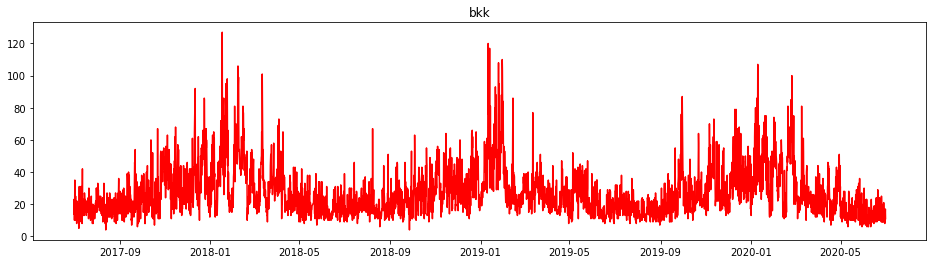

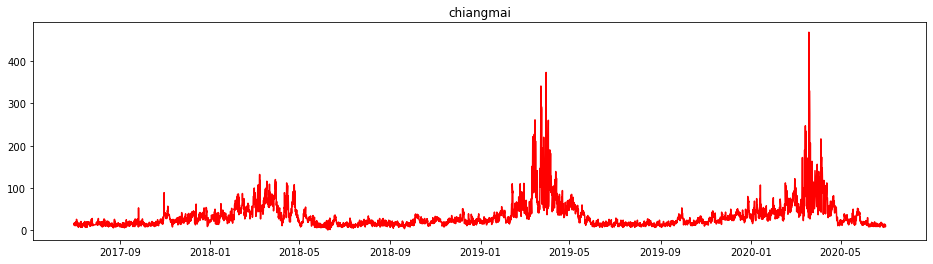

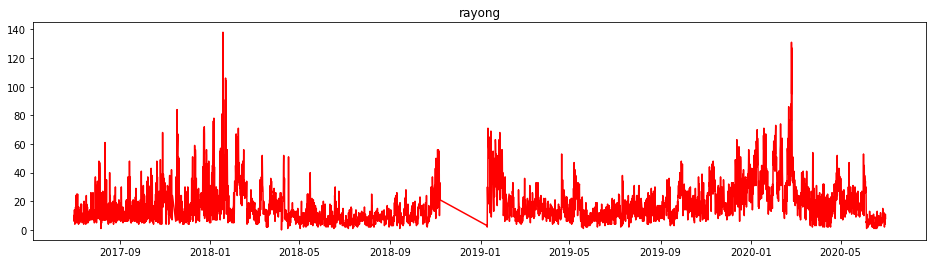

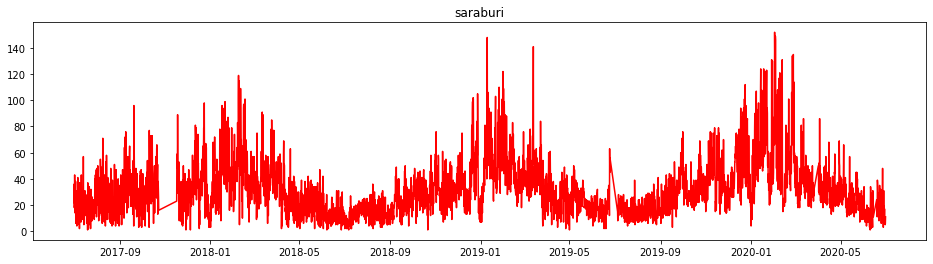

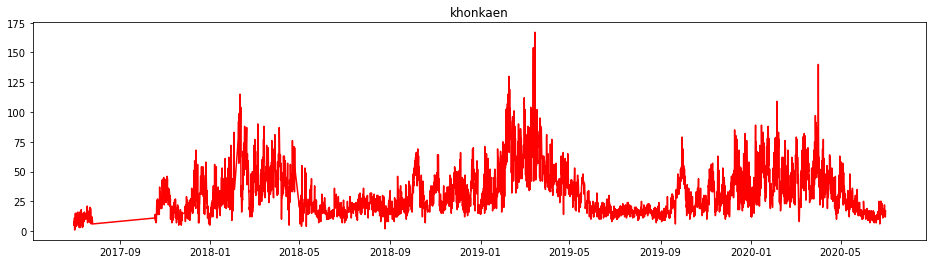

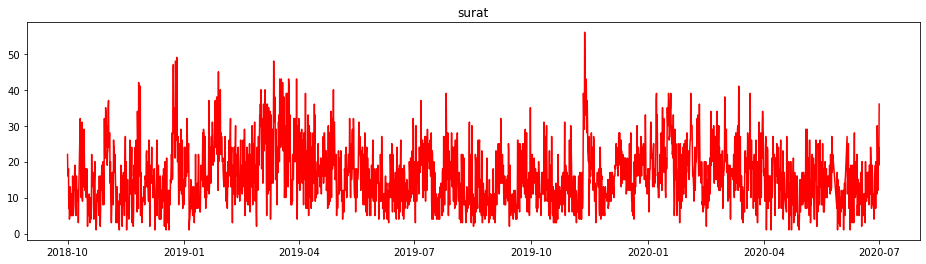

In [10]:
data_train = []

# 1.) Get PM2.5 train data
def getPM (folder,province):
    path = 'datasci_dataset_2022/{}/train/{}{}'.format(folder,province,train_name)
    df = pd.read_csv(os.path.abspath(path))

    # Setting DatetimeIndex and resample into 6-hour steps
    df['date_time'] = pd.to_datetime(df.iloc[:,0])
    df = df.iloc[: , 1:]
    df = df.set_index('date_time')
    df = df.resample('6h').ffill() 
    
    # Impute missing value
    df['PM2.5'].interpolate(limit_direction="both",inplace = True)

    # Visualize the data
    plt.figure(figsize=(16,4))
    plt.title(province)
    plt.plot(df,'r')

    # Rename by adding province to its name
    mapper = {
        "PM2.5": province+'_PM2.5',
    }
    df = df.rename(columns=mapper)

    # Add to data_train
    data_train.append(df)

for p in province:
    getPM(p[0],p[1])

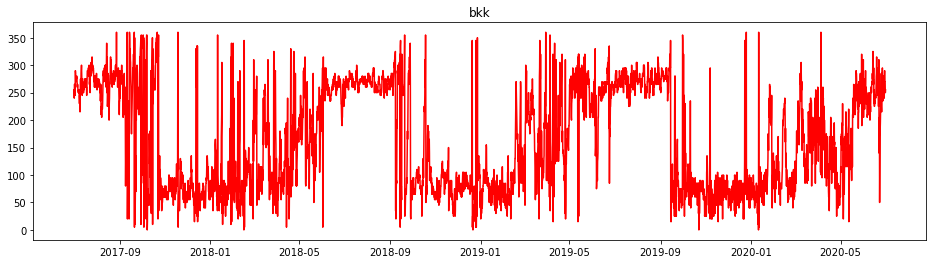

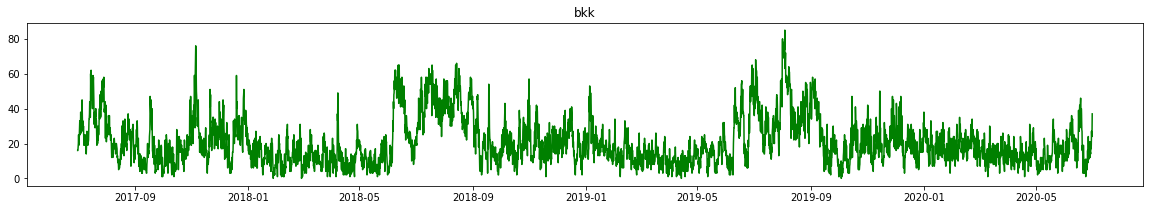

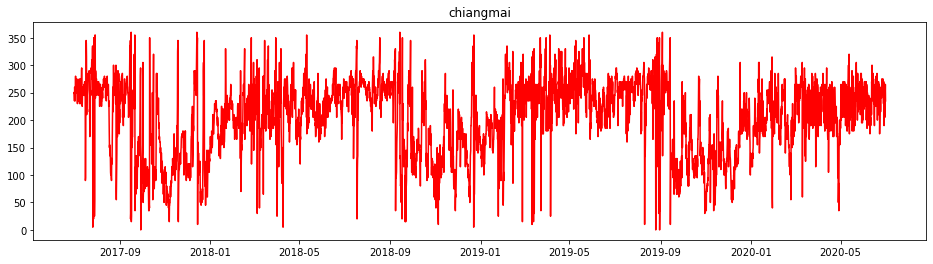

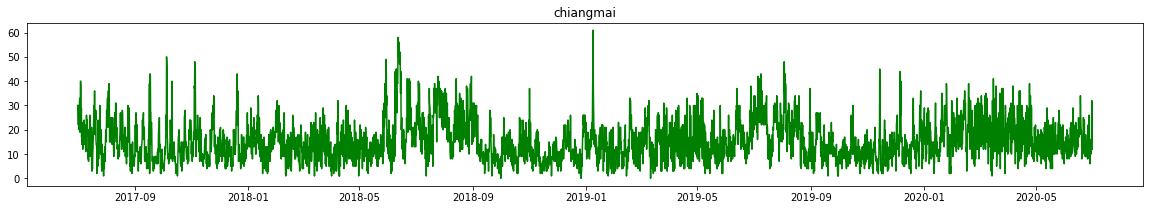

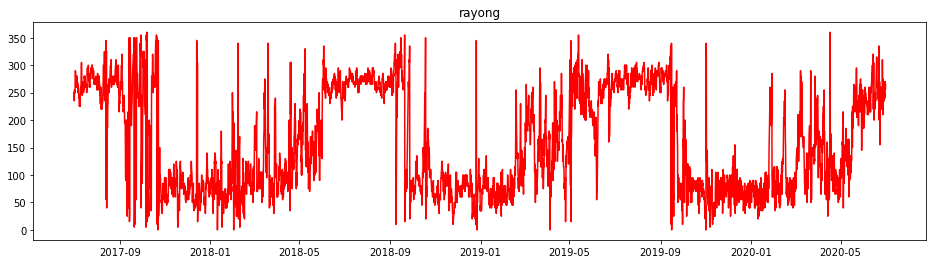

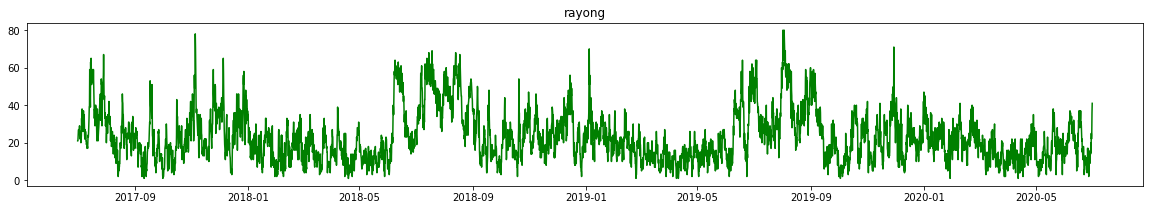

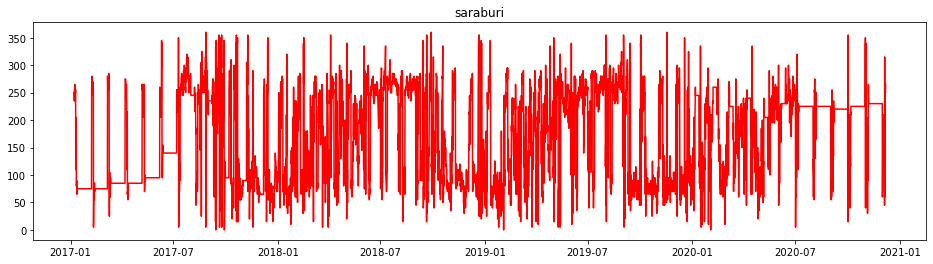

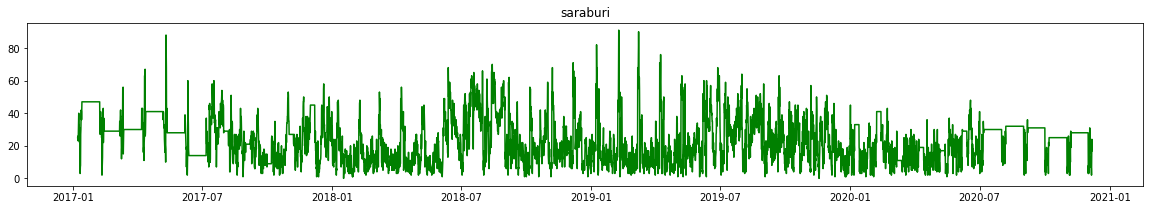

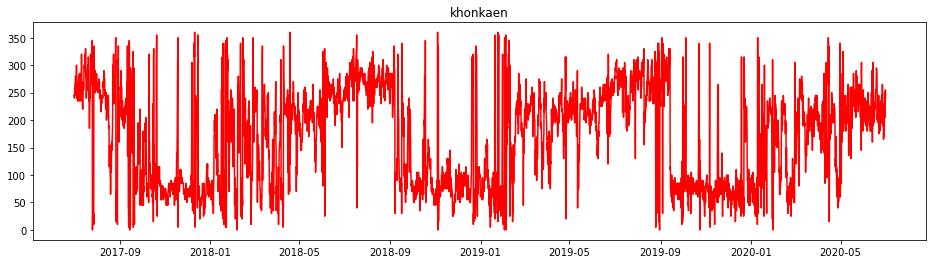

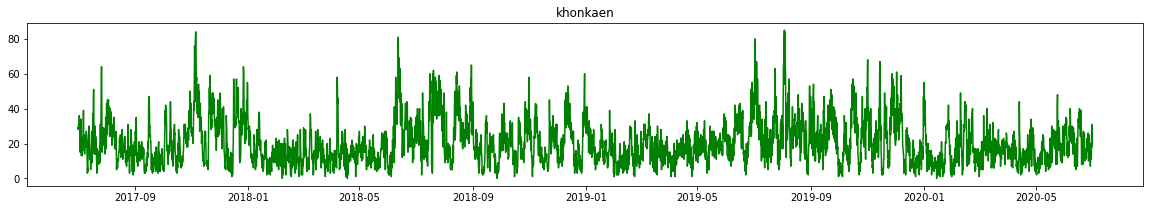

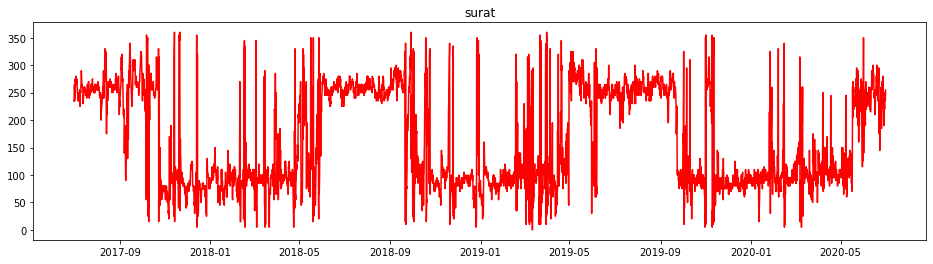

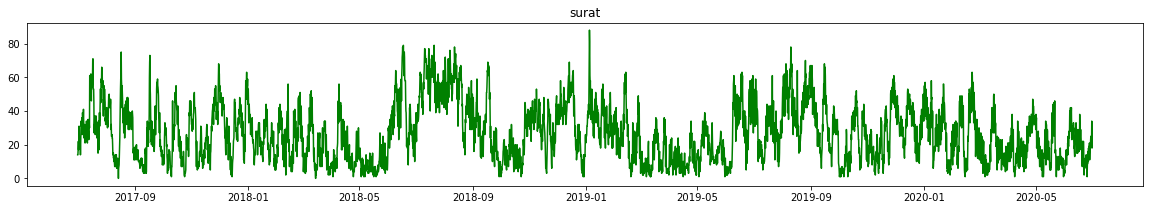

In [11]:
# 2.) Get Wind direction and Wind speed train data
def getWind(folder,province):
    path = 'datasci_dataset_2022/{}/train/{}{}'.format(folder,province,wind_name)
    wind_df = pd.read_csv(os.path.abspath(path), sep=',')

    # Setting DatetimeIndex and resample into 6-hour steps
    wind_df['date_time'] = pd.to_datetime(wind_df['date_time'])
    wind_df = wind_df.set_index('date_time')
    wind_df = wind_df.resample('6h').ffill() 

    # Impute missing value
    wind_df['wind dir'].interpolate(limit_direction="both",inplace = True)
    wind_df['wind speed'].interpolate(limit_direction="both",inplace = True)

    # Visualize the data
    plt.figure(figsize=(16,4))
    plt.title(province)
    plt.plot(wind_df["wind dir"],'r')
    plt.figure(figsize=(20,3))
    plt.title(province)
    plt.plot(wind_df["wind speed"],'g')

    # Rename by adding province to its name
    mapper = {
      'wind dir': province+'_WindDir',
      'wind speed': province+'_WindSpeed',
    }
    wind_df = wind_df.rename(columns=mapper)

    # Add to data_train
    data_train.append(wind_df[province+'_WindSpeed'])

for p in province:
    getWind(p[0],p[1])

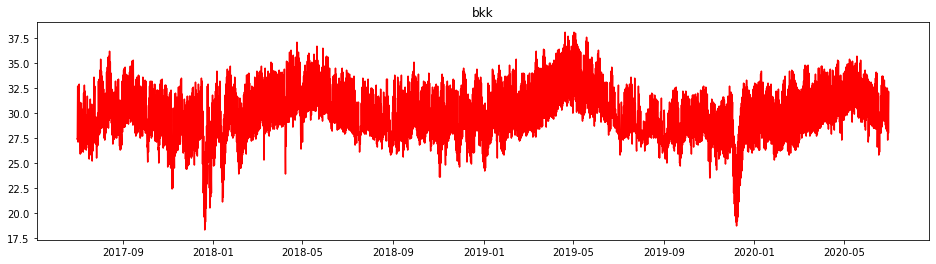

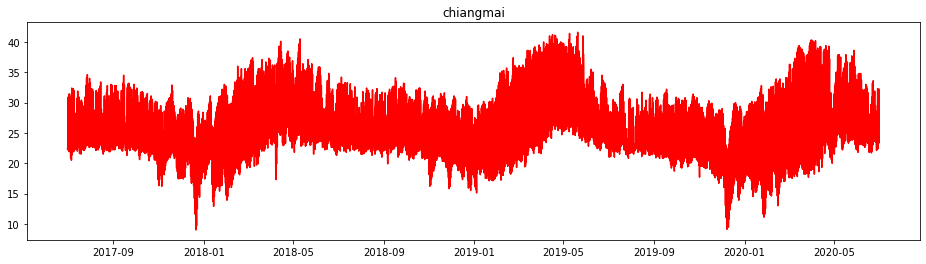

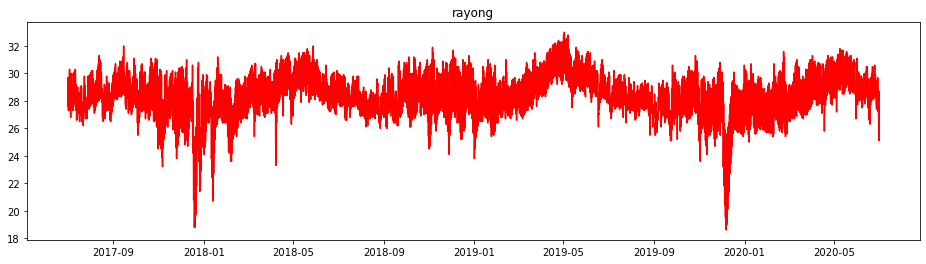

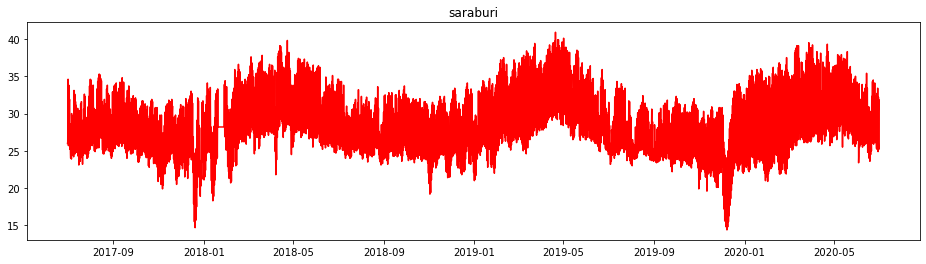

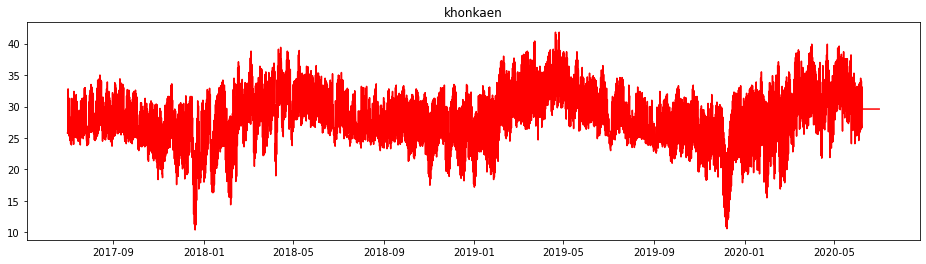

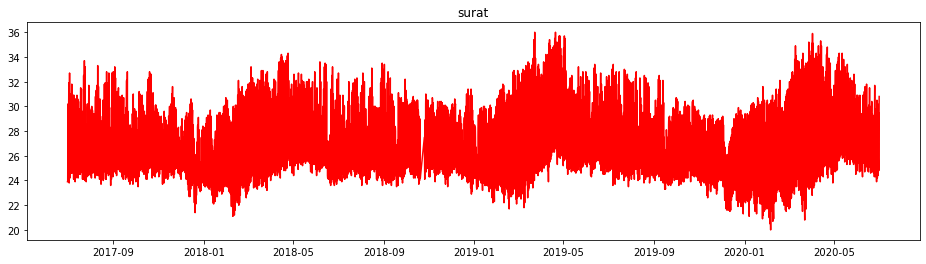

In [12]:
# 3.) Get Temperature train data
def getTemp(folder,province):
    path = 'datasci_dataset_2022/{}/train/{}{}'.format(folder,province,temp_name)
    temp_df = pd.read_csv(os.path.abspath(path), sep=',')

    # Setting DatetimeIndex and resample into 6-hour steps
    temp_df['date_time'] = pd.to_datetime(temp_df['date_time'])
    temp_df = temp_df.set_index('date_time')
    temp_df = temp_df.resample('6h').ffill() 

    # Impute missing value
    temp_df['temp'].interpolate(limit_direction="both",inplace = True)

     # Visualize the data
    plt.figure(figsize=(16,4))
    plt.title(province)
    plt.plot(temp_df,'r')

    # Rename by adding province to its name
    mapper = {
      'temp': province+'_Temp',
    }
    temp_df = temp_df.rename(columns=mapper)

    # Add to data_train
    data_train.append(temp_df)

for p in province:
    getTemp(p[0],p[1])

In [13]:
# Merging all train data
all_df = []
for i in range(6):
    df_train = data_train[i]
    for j in range(i+6,len(data_train),6):
        df_train = pd.merge( df_train, data_train[j], how="inner",left_index=True, right_index=True)
    df_train = df_train.reindex(sorted(df_train.columns), axis=1)
    all_df.append(df_train)
all_df[0]

,bkk_PM2.5,bkk_Temp,bkk_WindSpeed
date_time,,,
2017-07-01 00:00:00,14.0,27.4,16.0
2017-07-01 06:00:00,23.0,27.4,16.0
2017-07-01 12:00:00,15.0,31.1,18.0
2017-07-01 18:00:00,10.0,32.7,20.0
2017-07-02 00:00:00,17.0,28.6,25.0
...,...,...,...
2020-06-29 18:00:00,8.0,32.2,19.0
2020-06-30 00:00:00,9.0,29.6,27.0
2020-06-30 06:00:00,14.0,28.0,24.0


### Join Hotspot and Traffic to Train Data

In [14]:
for i in range(6):
    len_ = all_df[i].shape[0]
    all_df[i] = pd.merge( all_df[i], hotspot, how="inner",left_index=True, right_index=True)
    all_df[i] = pd.merge( all_df[i], traffic, how="inner",left_index=True, right_index=True)
all_df[5]

,surat_PM2.5,surat_Temp,surat_WindSpeed,Cambodia,Lao_PDR,Thailand,Myanmar,index
2018-10-01 00:00:00,22.0,26.6,3.0,1,0,1,0,1.555224
2018-10-01 06:00:00,16.0,25.2,1.0,1,0,1,0,5.098507
2018-10-01 12:00:00,16.0,30.2,4.0,1,0,1,0,5.179710
2018-10-01 18:00:00,18.0,30.6,3.0,1,0,1,0,4.652941
2018-10-02 00:00:00,7.0,26.2,6.0,1,0,0,0,1.697143
...,...,...,...,...,...,...,...,...
2020-06-29 18:00:00,12.0,29.5,23.0,3,0,4,0,4.023611
2020-06-30 00:00:00,21.0,25.8,20.0,0,0,2,0,1.701389
2020-06-30 06:00:00,24.0,24.8,34.0,0,0,2,0,4.681944
2020-06-30 12:00:00,19.0,28.7,18.0,0,0,2,0,5.298611


## Get Test Data

In [15]:
# 1.)  Get WindDir, WindSpeed,and Temp from scraped dataset
def pullScrapedWT(province):
  path = 'scraped_dataset/wind_temp/wt_'+province+'.csv'
  df_wt = pd.read_csv(os.path.abspath(path))

  # Setting DatetimeIndex
  ## slice last 6 characters(" Local")
  df_wt['DateTime'] = pd.to_datetime(df_wt['DateTime'].str.slice(0,-6))
  df_wt = df_wt.set_index('DateTime')

  # Impute missing value
  df_wt['Wind'].interpolate(inplace = True)
  df_wt['Temp'].interpolate(inplace = True)

  # Seperate wind direction and wind speed columns (scraped format: _winddir_° @ _windspeed_)
  tmp = df_wt['Wind'].str.split("° @ ")
  df_wt['WindDir'] = [float(tmp[i][0]) for i in range(len(tmp))]
  df_wt['Wind']    = [float(tmp[i][1]) for i in range(len(tmp))]
  ## chang dtype of Temp column to float
  df_wt['Temp'] = pd.to_numeric(df_wt['Temp'] ,errors = 'coerce')

  # Resample into 6-hour steps
  df_wt = df_wt.resample('6h').ffill()

  # Drop Unused rows and columns
  df_wt = df_wt.drop(['Province'], axis=1)
  df_wt = df_wt.iloc[1:,:]

  # Rename by adding province to its name
  mapper = {
    'WindDir': province+'_WindDir',
    'Wind': province+'_WindSpeed',
    'Temp': province+'_Temp',
  }
  df_wt = df_wt.rename(columns=mapper)

  return df_wt[[province+'_WindSpeed', province+'_Temp']]

In [16]:
# 2.)  Get PM2.5 test data
def pullTest(folder,province):
  path = 'datasci_dataset_2022/'+folder+'/test/'+province+'_test.csv'
  df_test = pd.read_csv(os.path.abspath(path))

  # Setting DatetimeIndex and resample into 6-hour steps
  df_test['DateTime'] = pd.to_datetime(df_test.iloc[:,0])
  df_test = df_test.iloc[: , 1:]
  df_test = df_test.set_index('DateTime')
  df_test = df_test.resample('6h').ffill() 

  # Impute missing value
  df_test.interpolate(inplace = True)

  # Rename by adding province to its name
  mapper = {
    'PM2.5': province+'_PM2.5',
  }
  df_test = df_test.rename(columns=mapper)
    
  return df_test

In [17]:
# Merging all test data
all_test = []
for p in province:
  df_train = pd.merge( pullScrapedWT(p[1]), 
                    pullTest(p[0],p[1]), 
                    how="inner",
                    left_index=True, 
                    right_index=True
                    )
  # df_train.interpolate(method='linear',limit_direction='backward',inplace=True)
  df_train = df_train.reindex(sorted(df_train.columns), axis=1)
  all_test.append(df_train)
all_test[5]

,surat_PM2.5,surat_Temp,surat_WindSpeed
DateTime,,,
2020-07-01 00:00:00,19.0,25.9,5.0
2020-07-01 06:00:00,23.0,24.7,6.0
2020-07-01 12:00:00,18.0,29.3,10.0
2020-07-01 18:00:00,16.0,31.8,9.0
2020-07-02 00:00:00,18.0,25.9,5.0
...,...,...,...
2021-06-30 18:00:00,12.0,28.7,9.0
2021-07-01 00:00:00,11.0,24.9,6.0
2021-07-01 06:00:00,11.0,23.8,6.0


### Join Hotspot and Traffic to Test Data

In [18]:
for i in range(len(all_test)):
  len_ = all_df[i].shape[0]
  all_test[i] = pd.merge(all_test[i], hotspot, 
                        how="inner",
                        left_index=True, 
                        right_index=True)
  all_test[i] = pd.merge(all_test[i], traffic, 
                        how="inner",
                        left_index=True, 
                        right_index=True)
all_test[5]

,surat_PM2.5,surat_Temp,surat_WindSpeed,Cambodia,Lao_PDR,Thailand,Myanmar,index
DateTime,,,,,,,,
2020-07-01 00:00:00,19.0,25.9,5.0,0,0,0,0,1.805556
2020-07-01 06:00:00,23.0,24.7,6.0,0,0,0,0,5.062500
2020-07-01 12:00:00,18.0,29.3,10.0,0,0,0,0,5.230556
2020-07-01 18:00:00,16.0,31.8,9.0,0,0,0,0,4.530556
2020-07-02 00:00:00,18.0,25.9,5.0,0,0,0,0,1.722222
...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,12.0,28.7,9.0,5,0,0,0,3.493056
2021-07-01 00:00:00,11.0,24.9,6.0,6,0,2,0,1.886111
2021-07-01 06:00:00,11.0,23.8,6.0,6,0,2,0,3.494444


## Declare Exogenous columns

In [19]:
exog_columns = []
not_exog_columns = []
for i in range(6) :
    exog_columns.append(list(all_df[i].columns[1:])) # not include y
    not_exog_columns.append(all_df[i].columns[0])
print("Exog: ", exog_columns[0])
print("\nNot Exog: ", not_exog_columns[0])

Exog:  ['bkk_Temp', 'bkk_WindSpeed', 'Cambodia', 'Lao_PDR', 'Thailand', 'Myanmar', 'index']

Not Exog:  bkk_PM2.5


# Building SARIMAX Models

In [20]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

## 0.) Tuning Hyperparameters with Grid Search

In [21]:
# List all possible SARIMAX order(p,d,q) and season order(P,D,Q,s)
p = range(0,3) #0-2
d = range(0,2) #0-1
q = range(0,3) #0-2
P = range(0,2) #0-1
D = range(0,2) #0-1
Q = range(0,2) #0-1
s = [4] #4
# p+q <= 2
# d <= 2
# d+D <= 2
# P+Q <=1
pdq = list(itertools.product(p, d, q))
pdqs = list(itertools.product(P, D, Q, s))

In [22]:
# Define Parameter Ranges to do SARIMAX grid search
def sarimax_gridsearch(ts_not, ts_exg, pdq, pdqs, maxiter=50, freq='6H'):
  ans = []
  for comb in pdq:
    for combs in pdqs:
      try:
        mod = SARIMAX(endog = ts_not, # PM2.5
                                        exog  = ts_exg,
                                        order=comb,
                                        seasonal_order=combs,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False,
                                        freq=freq)
        output = mod.fit(maxiter=maxiter) 
        ans.append([comb, combs, output.bic])
        # print('SARIMAX {} x {} : BIC Calculated = {}'.format(comb, combs, output.bic))
      except: continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:10]
  print('Paramaters that gives least BIC: ',ans_df)
  return ans_df

In [ ]:
# # Grid search for best order and seasonal order
# param_grid = []
# for i in range(6):
#   print(i)
#   param = sarimax_gridsearch(all_df[i][not_exog_columns[i]], 
#                             all_df[i][exog_columns[i]], 
#                             pdq, 
#                             pdqs, 
#                             freq='6H'
#                             )
#   param_grid.append(param)
# param_grid

## 1.) By Fitting with Train Data

In [33]:
model = [] # keep SARIMAXResultsWrapper for each province

# Best order and seasonal_order for each province from grid search 
for i in range(6):
    if(i==0):   # BKK
        best_order = (1,0,1)
        best_seasonal_order = (0,1,1,4)
    elif(i==1): # CM
        best_order = (1,0,1)
        best_seasonal_order = (0,1,1,4)
    elif(i==2): # Rayong
        best_order = (1,0,1)
        best_seasonal_order = (0,1,1,4)
    elif(i==3): # Saraburi
        best_order = (1,0,1)
        best_seasonal_order = (0,1,1,4)
    elif(i==4): # Khonkaen
        best_order = (1,0,1)
        best_seasonal_order = (0,1,1,4)
    elif(i==5): # Surat
        best_order = (1,0,1)
        best_seasonal_order = (0,1,1,4)

    mod = SARIMAX(endog = all_df[i][not_exog_columns[i]],
                  exog  = all_df[i][exog_columns[i]],
                  order = best_order,
                  seasonal_order = best_seasonal_order,
                  enforce_stationarity = False,
                  enforce_invertibility = False,
                  freq = "6H"
                  )
    results = mod.fit()
    model.append(results)

In [34]:
# # # Save a pickle of SARIMAX Results
!mkdir SARIMAX_pickle
model[0].save('SARIMAX_pickle/model_BKK.pickle')
model[1].save('SARIMAX_pickle/model_Chiangmai.pickle')
model[2].save('SARIMAX_pickle/model_Rayong.pickle')
model[3].save('SARIMAX_pickle/model_Saraburi.pickle')
model[4].save('SARIMAX_pickle/model_Khonkaen.pickle')
model[5].save('SARIMAX_pickle/model_Surat.pickle')

## 2.) By Loading SARIMAX Pickles

In [35]:
# # Download SARIMAX pickles from google cloud storage
# !wget https://storage.googleapis.com/pm25_pickle/SARIMAX_pickle.zip
# !unzip SARIMAX_pickle.zip

In [36]:
# # Load Model from pickle
# model = []
# for p in province:
#   filename = "SARIMAX_pickle/model_"+p[0]+".pickle"
#   results = SARIMAXResults.load(filename)
#   model.append(results)

---
Example of  Sarimax Results Summary

In [37]:
model[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         bkk_PM2.5   No. Observations:                 4382
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 4)   Log Likelihood              -16013.606
Date:                           Sat, 26 Mar 2022   AIC                          32049.212
Time:                                   01:14:56   BIC                          32119.425
Sample:                               07-01-2017   HQIC                         32073.988
                                    - 06-30-2020                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
bkk_Temp          0.5552      0.181      3.062      0.002       0.200       0.911
bkk_WindSpeed    -0.0716      0.027     -2.698      0.007      -0.124      -0.020
Cambodia          0.0062      0.002      3.924      0.000       0.003       0.009
Lao_PDR          -0.0006      0.002     -0.344      0.731      -0.004       0.003
Thailand          0.0052      0.004      1.185      0.236      -0.003       0.014
Myanmar           0.0004      0.002      0.203      0.839      -0.004       0.005
index             0.9117      0.217      4.204      0.000       0.487       1.337
ar.L1             0.8600      0.009     90.978      0.000       0.841       0.878
ma.L1            -0.4486      0.015    -29.729      0.000      -0.478      -0.419
ma.S.L4          -0.9222      0.005   -187.212      0.000      -0.932      -0.913
sigma2           88.8230      1.185     74.952      0.000      86.500      91.146
===================================================================================
Ljung-Box (L1) (Q):                  17.32   Jarque-Bera (JB):              2490.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.68
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Prediction and Evaluation

In [38]:
def RMSE(test,pred):
    mse = mean_squared_error(test, pred)
    rmse = math.sqrt(mse)
    print('Test on SARIMAX with RMSE: %f' % (rmse, ))

Forcasting next 12 data points and keep in dataframe

In [39]:
kaggle_pred = pd.DataFrame()
for i in range(6):
    result = model[i]
    print(i)
    for j in range(all_test[i].shape[0]-1):
        new_index = pd.date_range(start=all_test[i].index[j], periods=1, freq='6H')
        new_obs = pd.Series(all_test[i][not_exog_columns[i]].iloc[j:j+1], index=pd.to_datetime(new_index.strftime('%Y-%m-%d %H:%M:%S')))
        
        # Recreate the results object with new data used for forecasting
        result = result.append(endog = new_obs, 
                               exog  = all_test[i][exog_columns[i]].iloc[j:j+1]
                               )
        
        # Forecasting next 12 steps
        if j+13 > all_test[i].shape[0]:
          # Trimming tail of test data
          x = result.forecast(steps = 12-(j+13-all_test[i].shape[0]),
                              exog  = all_test[i][exog_columns[i]].iloc[j+1:]
                              )
        else:
          x = result.forecast(steps = 12, 
                              exog  = all_test[i][exog_columns[i]].iloc[j+1:j+13]
                              )
        kaggle_pred = pd.concat((kaggle_pred,x),axis=0)
kaggle_pred

0
1
2
3
4
5


,0
2020-07-01 06:00:00,16.689578
2020-07-01 12:00:00,15.039985
2020-07-01 18:00:00,11.334177
2020-07-02 00:00:00,9.710942
2020-07-02 06:00:00,16.993745
...,...
2021-07-01 12:00:00,14.416067
2021-07-01 18:00:00,15.537919
2021-07-01 12:00:00,13.571546
2021-07-01 18:00:00,14.796266


Get Kaggle test data for evaluation

In [40]:
kaggle_test = pd.DataFrame()
for i in range(6):
  for j in range(all_test[i].shape[0]):
    if j+13 > all_test[i].shape[0]:
      kaggle_test = pd.concat((kaggle_test,all_test[i][not_exog_columns[i]].iloc[j+1:]),axis=0)
    else:
      kaggle_test = pd.concat((kaggle_test,all_test[i][not_exog_columns[i]].iloc[j+1:j+13]),axis=0)
kaggle_test

,0
2020-07-01 06:00:00,11.0
2020-07-01 12:00:00,15.0
2020-07-01 18:00:00,14.0
2020-07-02 00:00:00,18.0
2020-07-02 06:00:00,12.0
...,...
2021-07-01 12:00:00,13.0
2021-07-01 18:00:00,13.0
2021-07-01 12:00:00,13.0
2021-07-01 18:00:00,13.0


In [41]:
# # Save the results
# kaggle_pred.to_csv('kaggle_pred.csv')
# kaggle_test.to_csv('kaggle_test.csv')

In [42]:
# Load the results
# kaggle_pred = pd.read_csv('kaggle_pred.csv',parse_dates=[0], dayfirst=True, index_col=[0])
# kaggle_test = pd.read_csv('kaggle_test.csv',parse_dates=[0], dayfirst=True, index_col=[0])

In [43]:
RMSE( kaggle_pred, kaggle_test)

Test on SARIMAX with RMSE: 8.371337


## Visualization

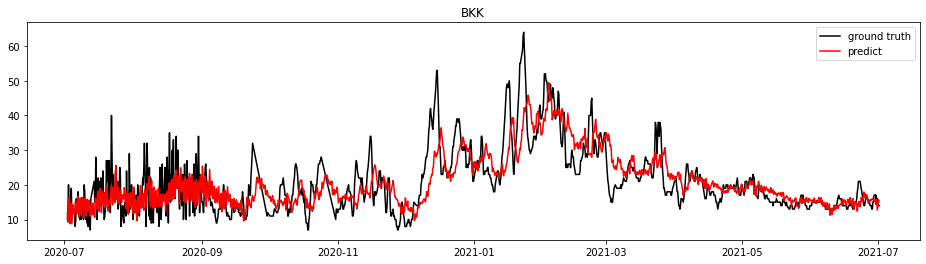

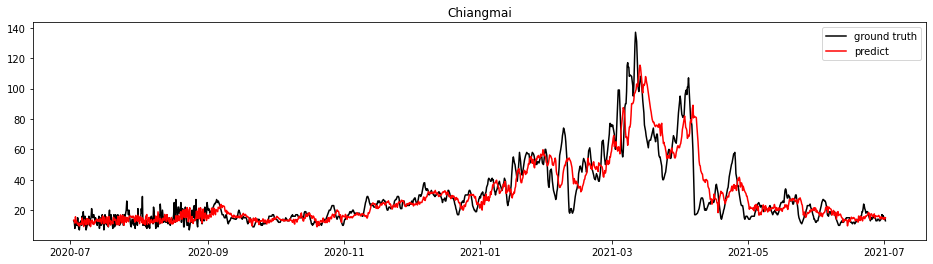

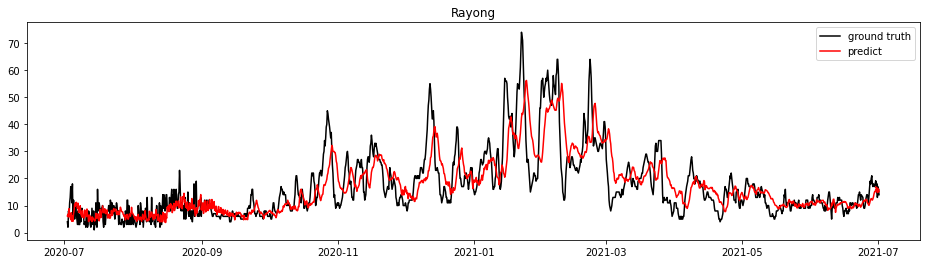

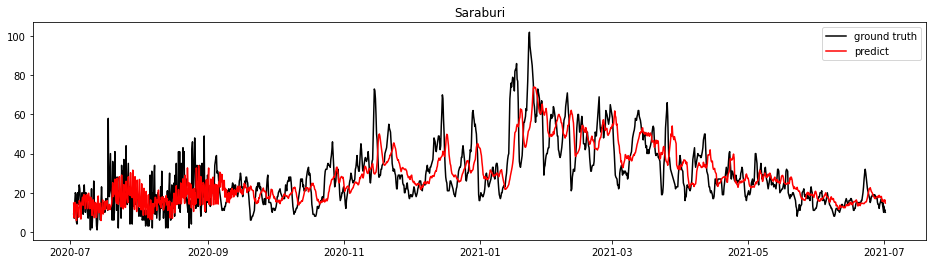

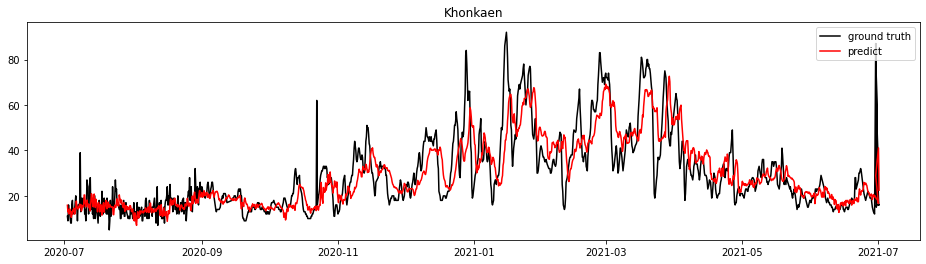

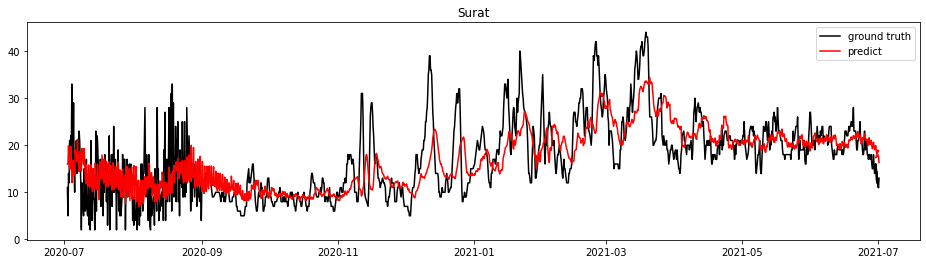

In [44]:
for i in range(6):
  plt.figure(figsize=(16, 4))
  start = 17490*i+6
  end = 17490*(i+1)+6 -12
  plt.plot(kaggle_test.iloc[start:end:12], color='black',label='ground truth')
  plt.plot(kaggle_pred.iloc[start:end:12], color='r',label='predict')
  plt.title(province[i][0])
  plt.legend(loc="upper right")
plt.show()

# Formatting for Kaggle Submission

In [45]:
# path = 'kaggle_pred.csv'
# kaggle_pred = pd.read_csv(os.path.abspath(path))

In [46]:
# Get Missing dates
def getMissingDate(province):
    path = 'datasci_dataset_2022/_missing_date/missing_test_date_'+province+'.csv'
    df = pd.read_csv(os.path.abspath(path))
    df['DateTime'] = pd.to_datetime(df['0'])
    df = df.drop(['0','Unnamed: 0'],axis=1)
    return df

missing = []
for p in province:
  missing.append(getMissingDate(p[1]))
missing[5]

,DateTime
0,2020-07-08 12:00:00
1,2020-07-09 18:00:00
2,2020-07-16 18:00:00
3,2020-08-10 00:00:00
4,2020-08-13 18:00:00
...,...
115,2021-06-05 18:00:00
116,2021-06-07 18:00:00
117,2021-06-16 12:00:00
118,2021-06-24 00:00:00


In [47]:
# Seperate predictions into 6 provinces
pred = []
for i in range(6):
    pred.append(kaggle_pred.iloc[i*17490:(i+1)*17490])
pred[5]

,0
2020-07-01 06:00:00,24.739149
2020-07-01 12:00:00,20.844491
2020-07-01 18:00:00,18.292256
2020-07-02 00:00:00,18.361365
2020-07-02 06:00:00,22.068561
...,...
2021-07-01 12:00:00,14.416067
2021-07-01 18:00:00,15.537919
2021-07-01 12:00:00,13.571546
2021-07-01 18:00:00,14.796266


In [48]:
# Exclude missing dates for each provinces
answer = pd.DataFrame()
for i in range(6):
    pred[i] = pred[i].reset_index()
    pred[i] = pred[i].rename(columns = {'index': 'DateTime'})
    pred[i]['DateTime'] = pd.to_datetime(pred[i]['DateTime'])    
    tmp = pred[i][~pred[i]['DateTime'].isin(missing[i]['DateTime'])]
    answer = pd.concat((answer,tmp),axis=0)
answer

,DateTime,0
0,2020-07-01 06:00:00,16.689578
1,2020-07-01 12:00:00,15.039985
2,2020-07-01 18:00:00,11.334177
3,2020-07-02 00:00:00,9.710942
4,2020-07-02 06:00:00,16.993745
...,...,...
17485,2021-07-01 12:00:00,14.416067
17486,2021-07-01 18:00:00,15.537919
17487,2021-07-01 12:00:00,13.571546
17488,2021-07-01 18:00:00,14.796266


In [49]:
# Format for Submission
answer = answer.drop(['DateTime'],axis=1)
answer['id'] = np.arange(len(answer))
answer = answer.set_index('id')
answer = answer.rename(columns = {0:'Predicted'})
answer

,Predicted
id,
0,16.689578
1,15.039985
2,11.334177
3,9.710942
4,16.993745
...,...
94243,14.416067
94244,15.537919
94245,13.571546


In [51]:
# # Save for submission
# answer.to_csv('kaggle_submission.csv')